In [1]:
from typing import List, Dict
import os

import matplotlib

import matplotlib.pyplot as plt
import datetime
import numpy as np
import json
import pandas




*Notebook wide constants*

In [2]:
session_directory = "Sport-sessions"
colors = ["b", "g", "r", "c", "m", "y", "k", "w"]
month_names = {
    1: "january",
    2: "february",
    3: "march",
    4: "april",
    5: "may",
    6: "june",
    7: "july",
    8: "august",
    9: "september",
    10: "october",
    11: "november",
    12: "december"
} 

*Functions*

In [3]:
def meters_to_miles(meters: float) -> float:
    """ Convert meters to miles
    """
    return 0.000621371 * meters

def directory_filenames(dir_: str, extension: str) -> List[str]:
    """ Return all filenames with a certain extension in a directory
    """
    extension = "." + extension
    filenames = []
    for f in os.listdir(session_directory):
        filename = os.path.join(session_directory, f)
        if not os.path.isfile(filename) or extension not in filename:
            continue
        filenames.append(filename)
    return filenames


class Run:
    def __init__(self, date: datetime.datetime, duration: float, distance: float) -> None:
        """ 
        Args:
            date (datetime.datetime): run date
            duration (float): The duration of the run, in minutes
            distance (float): The distance traveled
        """
        assert isinstance(date, datetime.datetime)
        assert isinstance(duration, float)
        assert isinstance(distance, float)
        self.date = date
        self.duration = duration
        self.distance = distance

    def __str__(self) -> str:
        return f"date: {self.date} duration: {round(self.duration, 2)}\tdistance: {self.distance}"

def get_runs(start_date: datetime.datetime, end_date: datetime.datetime):
    runs = []

    for filename in directory_filenames(session_directory, "json"):
        data = json.load(open(filename))

        run_date = datetime.datetime.fromtimestamp(data["start_time"] / 1000)
        run_duration_mins = data["duration"] / (1000 * 60)
        run_distance_mi = meters_to_miles(data["distance"])

        if run_date < start_date or run_date > end_date:
            continue
        if run_duration_mins > 5*60 or run_duration_mins < .001:
            continue     
        if run_distance_mi < .001:
            continue
        runs.append(Run(run_date, run_duration_mins, run_distance_mi))

    runs.sort(key=lambda r: r.date)
    return runs

def get_month_start_end(month: int, year):
    month_start_date = datetime.datetime(year=year, month=month, day=1)
    try:
        return month_start_date, datetime.datetime(year=year, month=month, day=31)
    except ValueError:
        try:
            return month_start_date, datetime.datetime(year=year, month=month, day=30)
        except ValueError:
            try:
                return month_start_date, datetime.datetime(year=year, month=month, day=29)
            except ValueError:
                return month_start_date, datetime.datetime(year=year, month=month, day=28)

def plot_cumulative(months: List[int]):
    
    plt.figure(figsize=(14, 6))
    date_range_str = "" #f"({month_names[months[0][0]].capitalize()} {months[0][1]}  - {month_names[months[-1][0]].capitalize()} {months[-1][1]})"
    plt.title(f"Days into Month vs Cumulative Distance Run {date_range_str}")
    plt.xlabel("Time")
    plt.ylabel("Distance (miles)")
    
    color_i = 0
    for month, year in months:
        
        start_date, end_date = get_month_start_end(month, year=year)
        runs = get_runs(start_date, end_date)

        cumulative_distance = 0
        days_in_month = []
        cumulative_distances = []
        distances = []

        for run in runs:
            cumulative_distance += run.distance
            days_in_month.append(run.date.day)
            cumulative_distances.append(cumulative_distance)
            distances.append(run.distance)
        
        days_in_month = np.array(days_in_month)
        distances = np.array(distances)
        
        color = colors[color_i]
        label = f"{month_names[month].capitalize()}, {year}"
        plt.plot(days_in_month, cumulative_distances, "-"+color, label=label)
        plt.fill_between(days_in_month, 0, cumulative_distances, color=color, alpha=.3)
                
        bar_plot_width = 1/(len(months) + 1)
        plt.bar(days_in_month + color_i * bar_plot_width + bar_plot_width/2 , distances, color=color, width=bar_plot_width)
        color_i += 1
    
    # Don't allow the axis to be on top of your data
    plt.grid(b=True, which="both", alpha=.2)
    plt.minorticks_on()
    ax = plt.axes()
    ax.set_axisbelow(b=True)
    
    plt.legend(frameon=False)
    
# TODO(@jeremysm)
def moving_average(dates, values, k):
    
    assert len(dates) == len(values)
    
    last_k = []
    
    for i, value in enumerate(values):
        pass
    
    
def plot_regular(start_yr_month_day, end_yr_month_day, plot_distance=True, plot_duration=True, plot_pace=True):
    start_date = datetime.datetime(year=start_yr_month_day[0], month=start_yr_month_day[1], day=start_yr_month_day[2])
    end_date = datetime.datetime(year=end_yr_month_day[0], month=end_yr_month_day[1], day=end_yr_month_day[2])
    runs = get_runs(start_date, end_date)

    dates = np.array([run.date for run in runs])
    durations = np.array([run.duration for run in runs])
    distances = np.array([run.distance for run in runs])
    ave_pace = [time / distance for time, distance in zip(durations, distances)]
    
    
    # Distance
    if plot_distance:
        plt.figure(figsize=(15, 6))
        plt.title("Date vs Run Distance")
        plt.xlabel("Date")
        plt.ylabel("Distance (miles)")
        plt.bar(dates, distances)

        plt.grid(b=True, which="both", alpha=.2)
        plt.minorticks_on()
        ax = plt.axes()
        ax.set_axisbelow(b=True)

    # Duration
    if plot_duration:
        plt.figure(figsize=(15, 6))
        plt.title("Date vs Run Duration")
        plt.xlabel("Date")
        plt.ylabel("Duration (minutes)")
        plt.bar(dates, durations)

        plt.grid(b=True, which="both", alpha=.2)
        plt.minorticks_on()
        ax = plt.axes()
        ax.set_axisbelow(b=True)
    
    # Pace
    if plot_pace:
        plt.figure(figsize=(15, 6))
        plt.title("Date vs Run Pace")
        plt.xlabel("Date")
        plt.ylabel("Pace (minutes / mile)")
        plt.bar(dates, ave_pace)

        plt.grid(b=True, which="both", alpha=.2)
        plt.minorticks_on()
        ax = plt.axes()
        ax.set_axisbelow(b=True)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:148: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:174: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


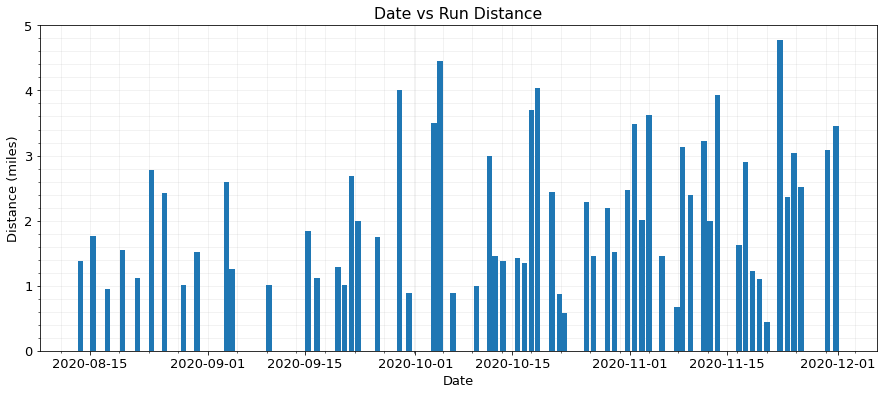

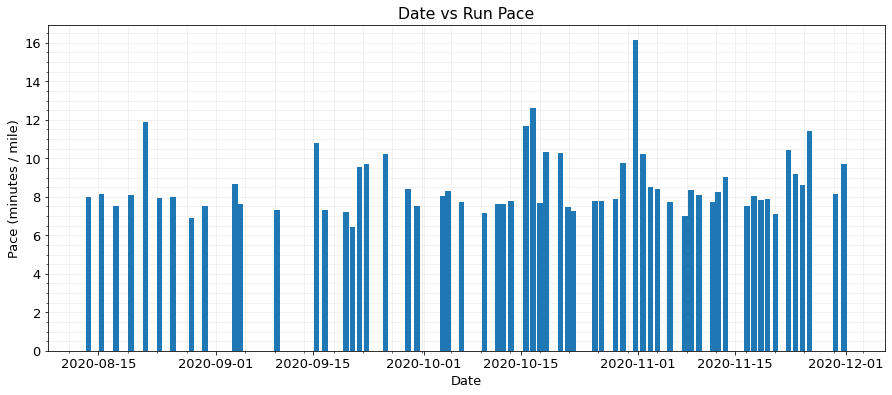

In [8]:
matplotlib.rcParams.update({'font.size': 13})


# First three months
start = [2020, 8, 1]
end = [2020, 12, 1]

# Last three months
# start = [2020, 12, 1]
# end = [2021, 2, 1]

plot_regular(start, end, plot_distance=True, plot_duration=False, plot_pace=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:111: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


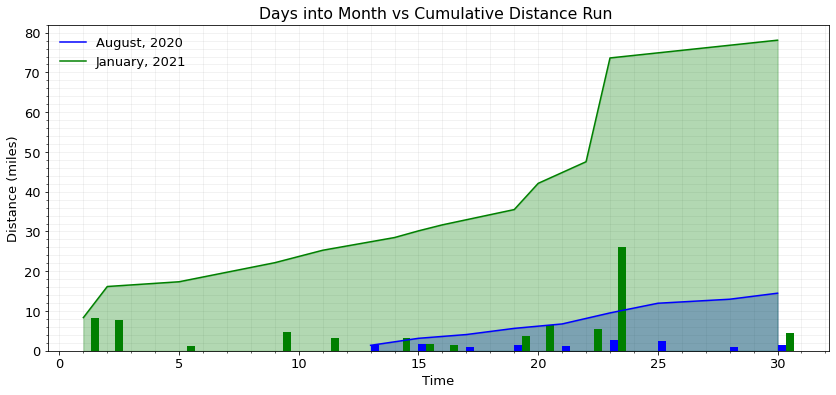

In [12]:
months = [
    [8, 2020],
    #[9, 2020],
    #[10, 2020],
#     [11, 2020],
    #[12, 2020],
    [1, 2021],
]

plot_cumulative(months)